In [1]:
%matplotlib inline
DEFAULT_FIGSIZE = (12, 8)

import itertools
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

sys.path.append('..')
from antlia.record import load_records
from antlia import plot_braking as braking

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE

In [2]:
records = load_records(sync=True)

Unable to determine range 2
Unable to determine range 1


In [3]:
import IPython.display

def animate_braking(rid, tid, xlim, ylim, speedup=1, **kwargs):
    record = records[rid]
    trial = record.trial[tid]
    
    m, _, _, _ = braking.get_metrics(trial.data)
    
    t0 = m['braking starttime']
    t1 = m['braking endtime']

    frames = record.lidar.frame(lambda t: (t >= t0 - 1) & (t < t1 + 1))
        
    c = sns.color_palette('Paired', 10)[1::2]
    colors = [c[2]
              if (t > t0) and (t < t1) else c[1]
              for t in frames.time]
    
    return frames.animate(xlim, ylim, speedup, colors, **kwargs)

def display_animation(animation):
    plt.close(animation._fig)
    IPython.display.display(IPython.display.HTML(ani.to_html5_video()))
    
    
for rid, tid in [[0, 6]]:
#for rid, tid in itertools.product(range(3, 4), range(1)):
    record = records[rid]
    trial = record.trial[tid]
    
    ani = animate_braking(rid, tid,
                          xlim=(0, 50),
                          ylim=(0, 2),
                          speedup=0.5,
                          plot_kwargs={'marker': 'o'})
    ani._fig.get_axes()[0].set_title('rider {} trial {:02d}'.format(rid, tid))
    display_animation(ani)

In [4]:
## calculate forward length
# We make some simplifications in the bicycle geometry
# (namely ignoring changes in roll and pitch, and mostly
# assuming yaw to be zero) as they will be small as we
# are near the nominal orientation.

bb_to_front_hub = 0.655 # m
front_wheel_radius = 0.359 # m
head_tube_angle = (90 - 72) * np.pi/180 # rad TODO: measure this

import sympy
import sympy.physics.vector as sv

yaw, steer = sympy.symbols('yaw steer')
N = sv.ReferenceFrame('N')
A = N.orientnew('A', 'axis', [yaw, N.z])
B = A.orientnew('B', 'axis', [head_tube_angle, A.y])
C = B.orientnew('C', 'axis', [steer, B.z])

# vector pointing from front hub center to most forward
# point on front wheel
n = sv.cross(C.y, N.z).normalize()

o = sv.Point('o')
p = o.locatenew('p', bb_to_front_hub*A.x + front_wheel_radius*n)

d = sv.dot(p.pos_from(o), N.x)

def forward_length(steer_angle, yaw_angle = 0):
    # distance from bottom bracket to front hub,
    # projected onto rear frame body fixed x-axis
    return d.subs({yaw: yaw_angle, steer: steer_angle})

print(forward_length(0))
print(forward_length(15*np.pi/180))
print(forward_length(-15*np.pi/180))
print(forward_length(30*np.pi/180))
print(forward_length(-30*np.pi/180))

1.01400000000000
1.00288180754931
1.00288180754931
0.969681991356316
0.969681991356316


rider 0, trial 2
average rider x: 42.97164073139187
trial dtc, fl = .580: 6.448359268608128
trial dtc, fl func: 6.02880269616110


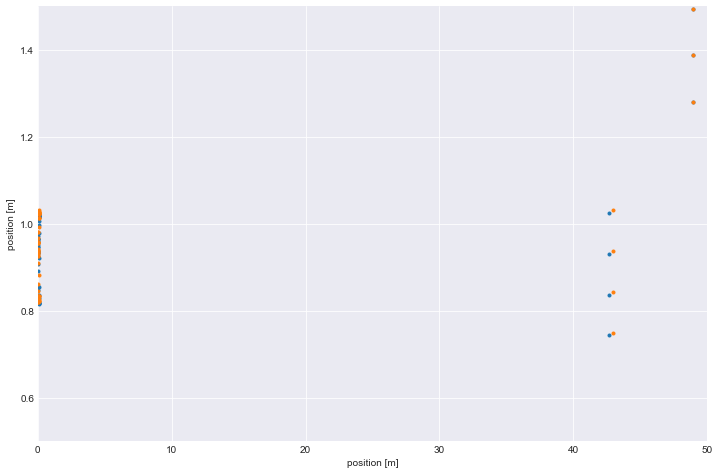

In [5]:
plt.close('all')
for rid, tid in [[0, 2]]:
    record = records[rid]
    trial = record.trial[tid]
    try:
        m, _, _, _ = braking.get_metrics(trial.data)
    except TypeError:
        continue
    print('rider {}, trial {}'.format(rid, tid))
    
    index1 = record.lidar.frame_index(m['braking starttime'][0])
    
    xlim = (0, 50)
    ylim = (0.5, 1.5)
    fig, ax = plt.subplots()
        
    x, y = record.lidar[index1 - 1].cartesian(xlim=xlim, ylim=ylim)
    ax.plot(x.compressed(), y.compressed(), linestyle=' ', marker='.')
    x, y = record.lidar[index1].cartesian(xlim=xlim, ylim=ylim)
    ax.plot(x.compressed(), y.compressed(), linestyle=' ', marker='.')
        
    ax.set_xlabel('position [m]')
    ax.set_ylabel('position [m]')
    ax.set_xlim((0, 50))
    ax.set_ylim(ylim)
    
    rider_x = x[np.where((x > 10) & (x < 48))] 
    print('average rider x: {}'.format(rider_x.mean()))
    
    # from bottom bracket to front wheel center
    # projected on inertia x-axis
    dtc1 = 50 - rider_x.mean() - 0.580
    print('trial dtc, fl = .580: {}'.format(dtc1))
    
    steer_angle = np.interp(m['braking starttime'][0],
                            trial.data.time,
                            trial.data['steer angle'])
    dtc2 = 50 - rider_x.mean() - forward_length(steer_angle)
    print('trial dtc, fl func: {}'.format(dtc2))
plt.show()

In [6]:
def calculate_dtc(rid, tid):
    record = records[rid]
    trial = record.trial[tid]
    m, _, _, _ = braking.get_metrics(trial.data)
        
    index = record.lidar.frame_index(m['braking starttime'][0])
    index = [-1 + index, index]
    
    xlim = (0, 50)
    ylim = (0.5, 1.5)
        
    dtc = []
    for i in index:
        x, _ = record.lidar[[i]].cartesian(xlim=xlim, ylim=ylim)
        x = x.compressed()
        rider_x = x[np.where((x > 10) & (x < 48))]
        
        steer_angle = np.interp(record.lidar[i].time[0],
                                trial.data.time,
                                trial.data['steer angle'])
        
        dtc.append(50 - rider_x.mean() - forward_length(steer_angle))
    
    dtc = np.array(dtc).astype(np.float64)
    t = record.lidar[np.array(index)].time.flatten()
    return np.interp(m['braking starttime'][0], t, dtc), m

calculate_dtc(0, 2)

(6.0975533337432655,
 array([ (-1.72348435,  715.84898323, -0.74410543,   2.76832297e-44,  0.0994677,  6.07819461,  1.952244,  8.70374047,  411.786928,  413.739172, 55, [2212, 2456], 0, 0, 0)],
       dtype=[('linregress slope', '<f8'), ('linregress intercept', '<f8'), ('linregress r-value', '<f8'), ('linregress p-value', '<f8'), ('linregress stderr', '<f8'), ('starting velocity', '<f8'), ('braking duration', '<f8'), ('braking distance', '<f8'), ('braking starttime', '<f8'), ('braking endtime', '<f8'), ('window size', '<i8'), ('braking range', '<i8', (2,)), ('lockup ranges', '<i8'), ('rider id', '<i8'), ('trial id', '<i8')]))

In [7]:
import pandas as pd

def get_dataframe(records):
    """Define function to get metrics for lidar data.
    """
    metrics = []
    dtc = []
    for rid, tid in itertools.product(range(4), range(15)):
        try:
            x, m = calculate_dtc(rid, tid)
        except TypeError:
            print('skipping {}, {}'.format(rid, tid))
            continue
        
        dtc.append(x)
        
        m['rider id'] = rid
        m['trial id'] = tid
        metrics.append(m)
        
    metrics = np.concatenate(metrics)
    # exclude non-scalar fields
    names = [dtype[0]
             for dtype in metrics.dtype.fields.items()
             if dtype[1][0].shape == ()]
    
    df = pd.DataFrame(metrics[names])
    df['distance-to-collision'] = dtc
    
    f = lambda row: row['distance-to-collision']/row['starting velocity']
    df['time-to-collision'] = df.apply(f, axis=1)
    return df
 
df = get_dataframe(records)
df.to_pickle('braking_ttc.p.gz')
# DTC/TTC calculations will be 'nan' if not detected by lidar
# lidar only has a guaranteed detection range of 30 m
df

skipping 0, 0
skipping 0, 1


/Users/oliver/miniconda3/envs/dev/lib/python3.5/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice.
/Users/oliver/miniconda3/envs/dev/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,linregress stderr,braking starttime,braking endtime,linregress p-value,linregress intercept,linregress slope,braking duration,trial id,window size,linregress r-value,lockup ranges,starting velocity,braking distance,rider id,distance-to-collision,time-to-collision
0,0.099468,411.786928,413.739172,2.768323e-44,715.848983,-1.723484,1.952244,2,55,-0.744105,0,6.078195,8.703740,0,6.097553,1.003185
1,0.514137,493.557209,494.157285,8.387193e-03,691.587816,-1.393157,0.600076,3,55,-0.302307,0,3.937731,2.140694,0,NaN,NaN
2,0.118824,571.154965,572.667154,5.695965e-23,773.491082,-1.345448,1.512189,4,55,-0.637766,0,4.857473,6.070381,0,7.685615,1.582225
3,0.213894,677.698360,678.858507,2.569676e-21,1630.390552,-2.397210,1.160147,5,55,-0.683830,0,5.533575,5.122003,0,5.334500,0.964024
4,0.130077,766.029467,767.317630,4.054087e-11,710.990535,-0.922756,1.288163,6,55,-0.490318,0,4.031114,4.557585,0,NaN,NaN
5,0.199042,846.439577,847.655731,1.672730e-15,1504.730026,-1.771827,1.216154,7,55,-0.587936,0,4.699092,4.753165,0,5.562428,1.183724
6,0.119038,910.143588,911.839800,1.107465e-34,1618.459859,-1.771589,1.696212,8,55,-0.716459,0,5.855901,7.729463,0,8.116734,1.386078
7,0.432361,1020.986526,1021.778623,9.763750e-05,1798.833210,-1.757588,0.792097,9,55,-0.381527,0,4.146971,2.901759,0,4.766233,1.149329
8,0.272392,1090.427257,1091.723418,7.108176e-09,1821.773991,-1.665790,1.296161,10,55,-0.435266,0,4.927042,5.537081,0,5.782857,1.173697
9,0.131949,1152.203024,1154.227278,4.058286e-25,1766.450561,-1.527542,2.024254,11,55,-0.589990,0,6.070815,9.849418,0,7.363308,1.212903


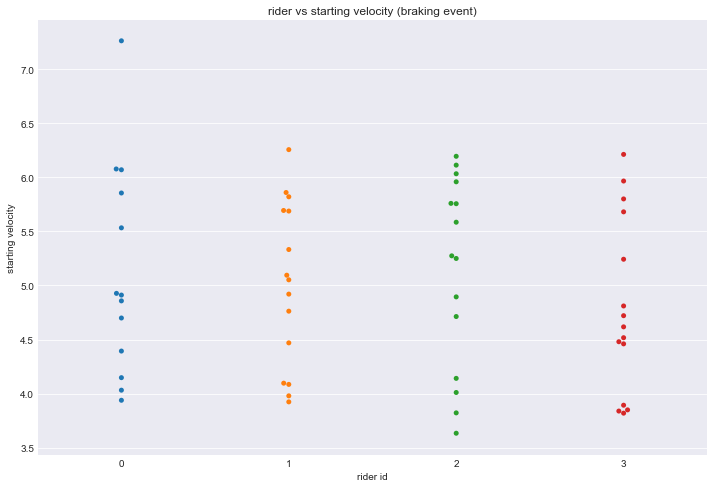

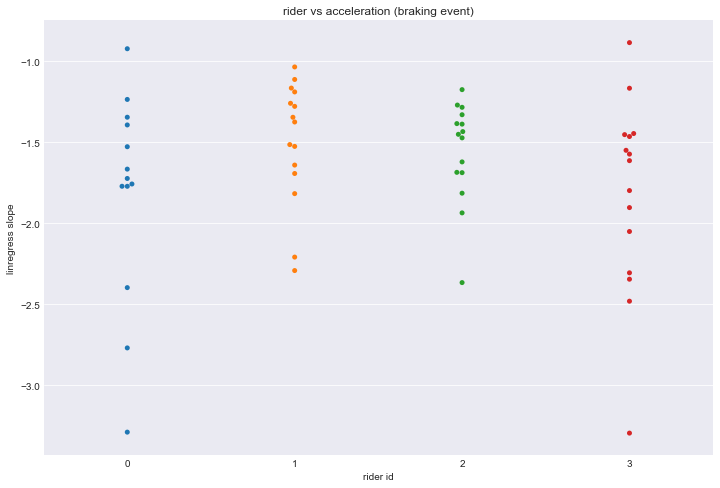

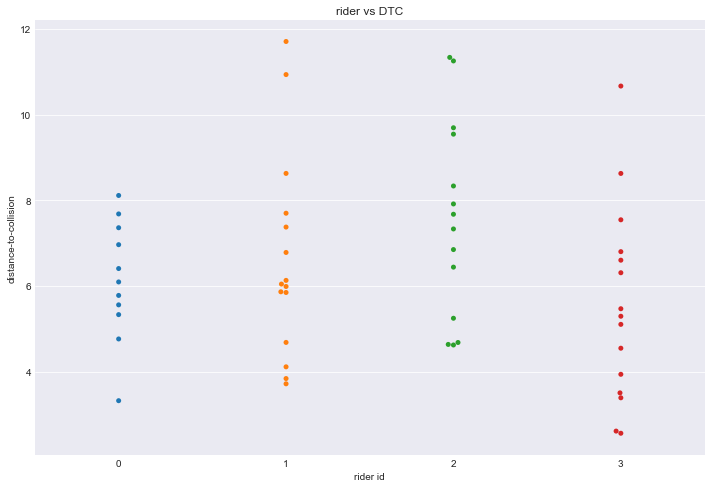

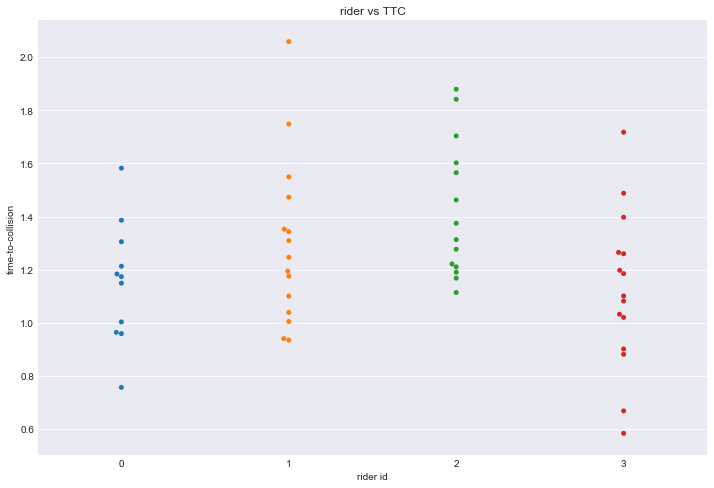

In [8]:
plt.close('all')
fig, ax = plt.subplots()
sns.swarmplot(x='rider id', y='starting velocity', data=df, ax=ax)
ax.set_title('rider vs starting velocity (braking event)')

fig, ax = plt.subplots()
sns.swarmplot(x='rider id', y='linregress slope', data=df, ax=ax)
ax.set_title('rider vs acceleration (braking event)')

fig, ax = plt.subplots()
sns.swarmplot(x='rider id', y='distance-to-collision', data=df, ax=ax)
ax.set_title('rider vs DTC')

fig, ax = plt.subplots()
sns.swarmplot(x='rider id', y='time-to-collision', data=df, ax=ax)
ax.set_title('rider vs TTC')
plt.show()

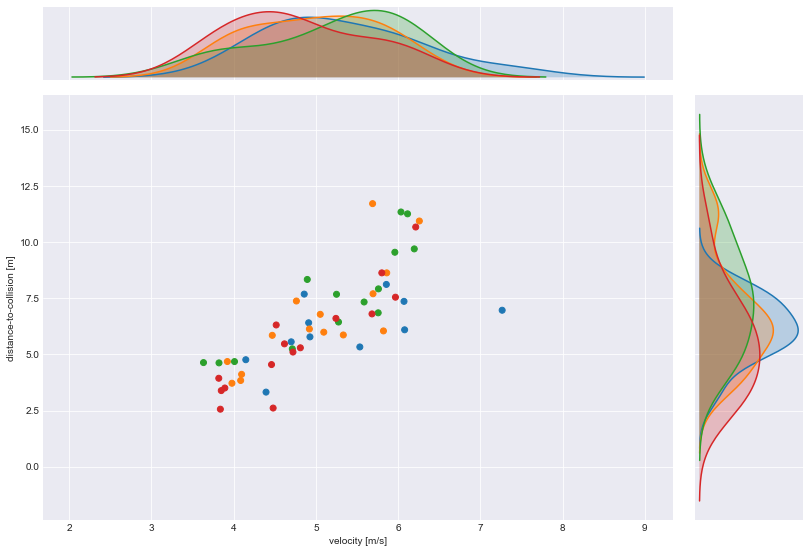

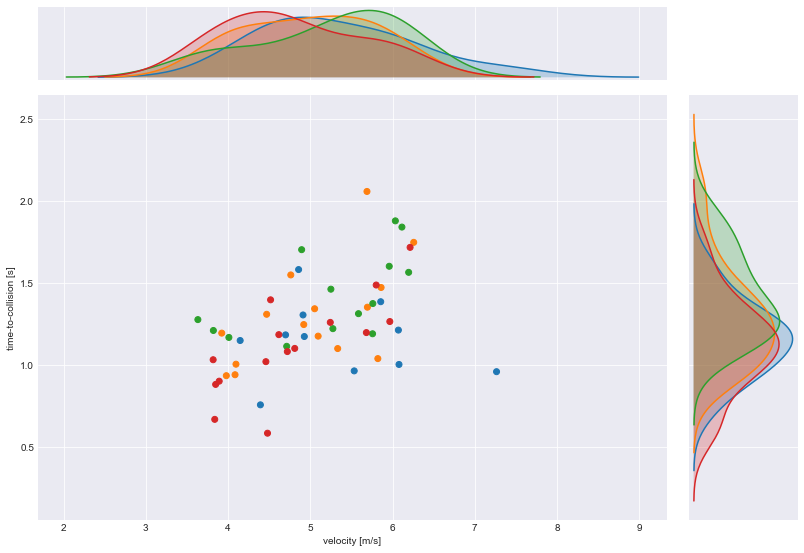

In [9]:
from antlia.plotdf import plotjoint

colors = sns.color_palette()

plt.close('all')
g = plotjoint('starting velocity', 'distance-to-collision',
              df[np.isfinite(df['time-to-collision'])],
              ('rider id', colors))
g.fig.set_size_inches(DEFAULT_FIGSIZE)
g.set_axis_labels('velocity [m/s]', 'distance-to-collision [m]')

g = plotjoint('starting velocity', 'time-to-collision',
              df[np.isfinite(df['time-to-collision'])],
              ('rider id', colors))
g.fig.set_size_inches(DEFAULT_FIGSIZE)
g.set_axis_labels('velocity [m/s]', 'time-to-collision [s]')
plt.show()